In [2]:
%%capture
!pip install mne

In [3]:
%%capture
!pip install seaborn

In [4]:
%%capture
!pip install sklearn

In [5]:
%%capture
!pip install joblib

In [1]:
%%capture
!pip install ray

In [3]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import mne  

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-m64tk8wa because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
def loaddata(fname):
    with open(fname,'rb') as handle:
        data = pickle.load(handle)
    return data
fname = 'ALSdata.pickle'
data = loaddata(fname)

In [3]:
s1 = data[0]
tget = s1['Target']
nontget = s1['NonTarget']
print(tget)

<Epochs |  700 events (all good), 0 - 0.601562 sec, baseline off, ~3.3 MB, data loaded,
 'Target': 700>


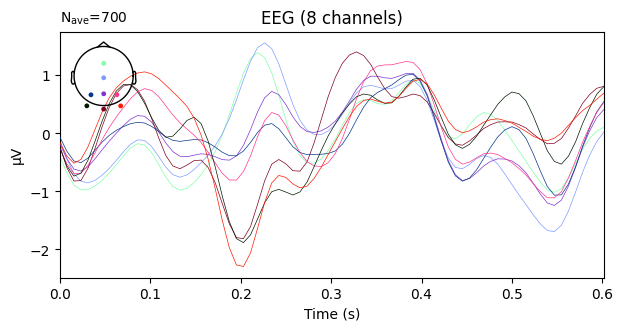

In [4]:
s1['Target'].average().plot();

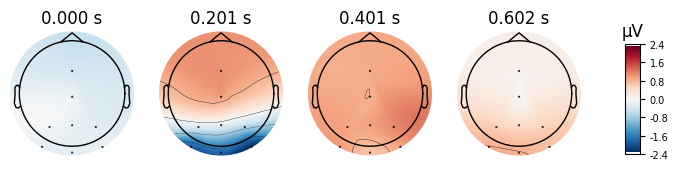

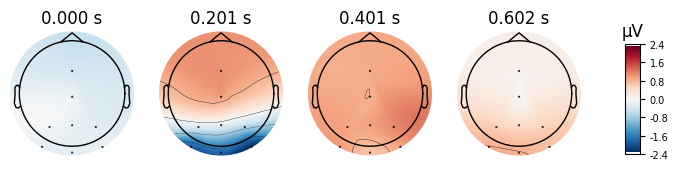

In [5]:
tget = s1['Target'].average()
tget.plot_topomap()

No projector specified for this dataset. Please consider the method self.add_proj.


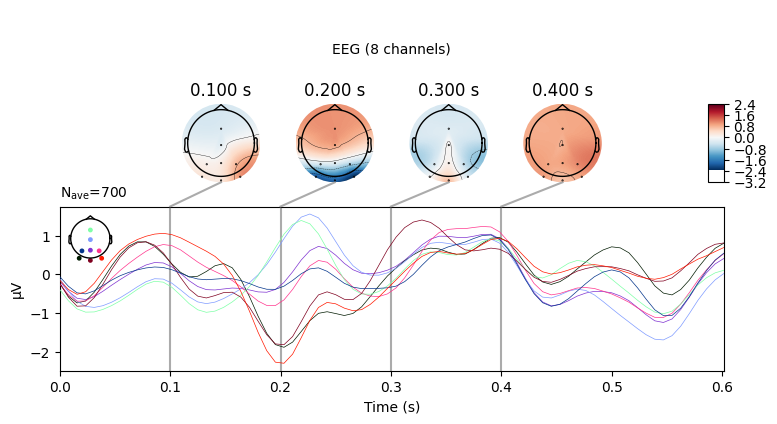

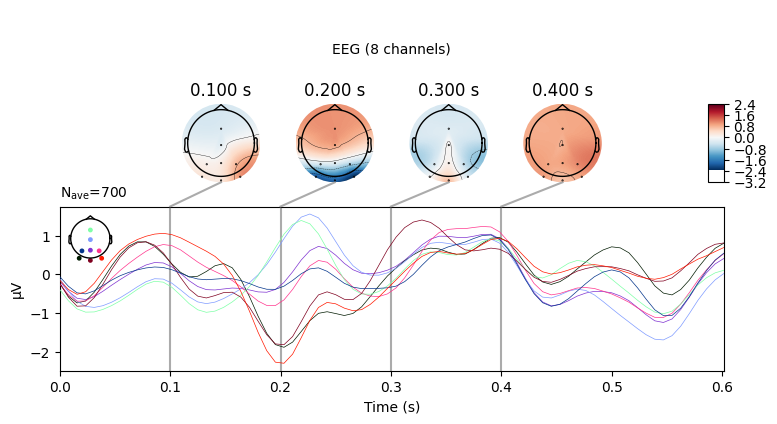

In [6]:
tget.plot_joint(times = [0.1,0.2,0.3,0.4])

No projector specified for this dataset. Please consider the method self.add_proj.


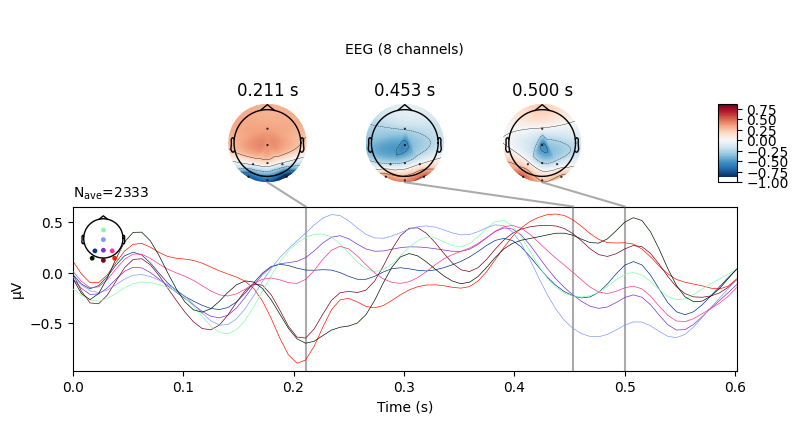

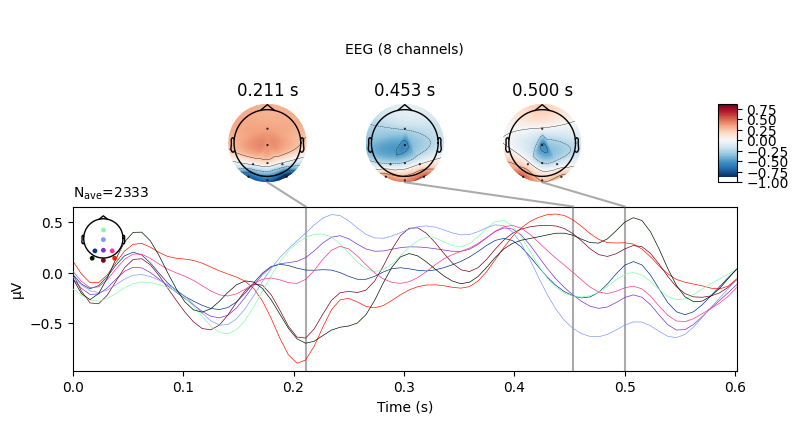

In [7]:
nontget = s1['NonTarget'].average()
diff = mne.combine_evoked((tget, -nontget), weights = 'equal')
times = [0.1,0.2,0.3,0.4]
diff.plot_joint()

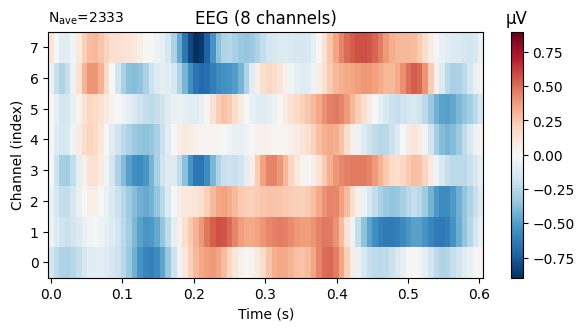

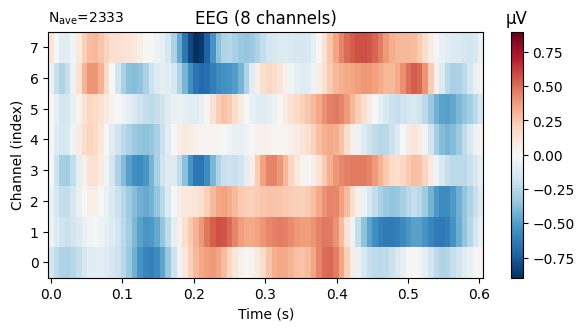

In [8]:
diff.plot_image()

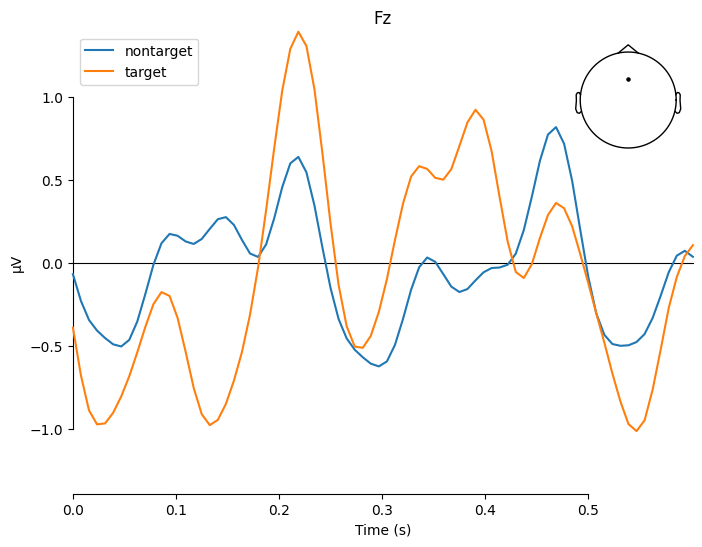

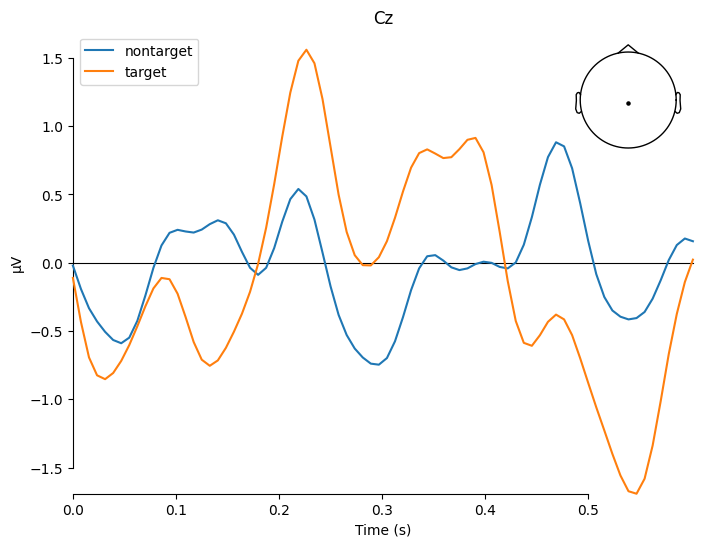

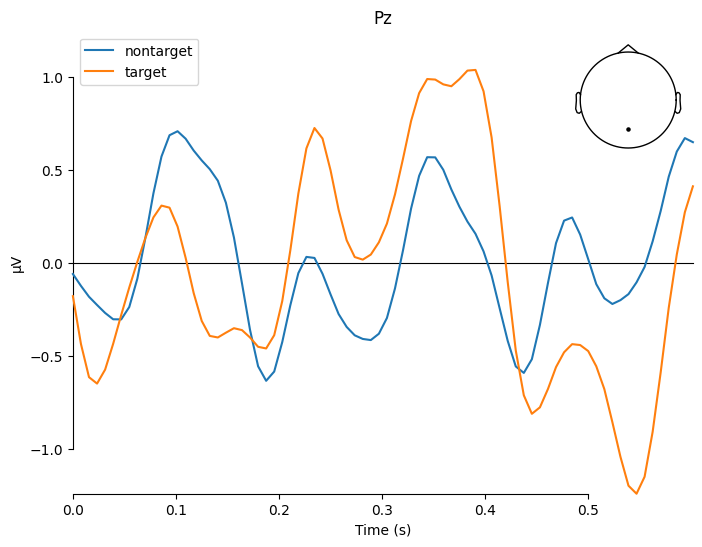

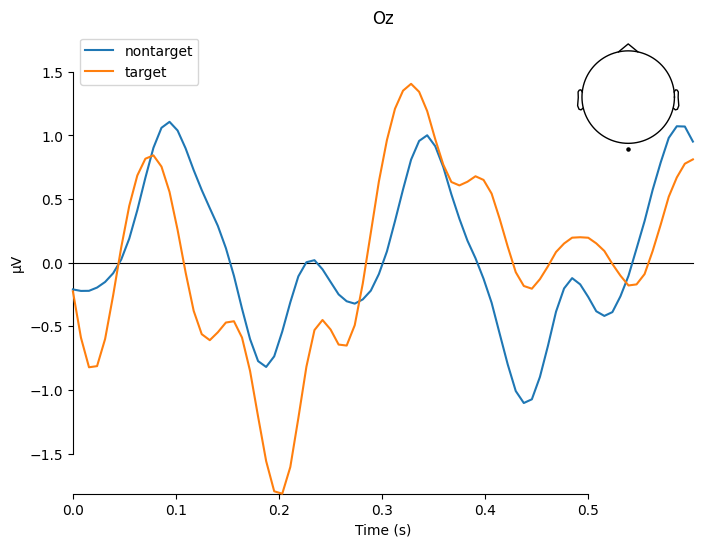

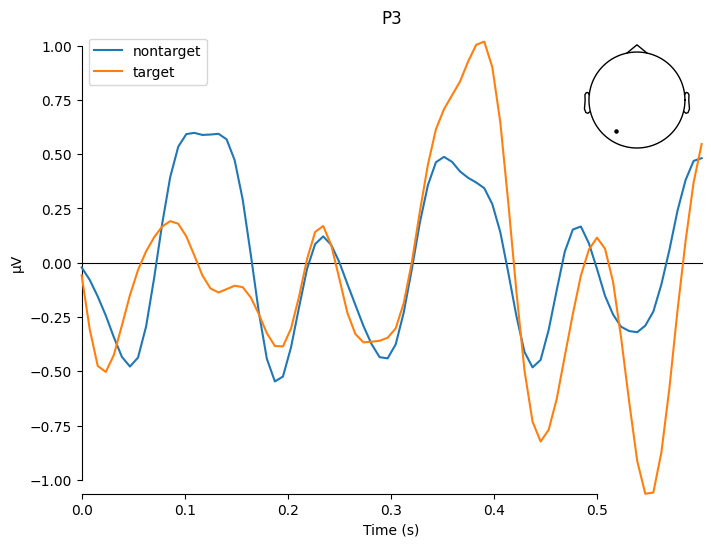

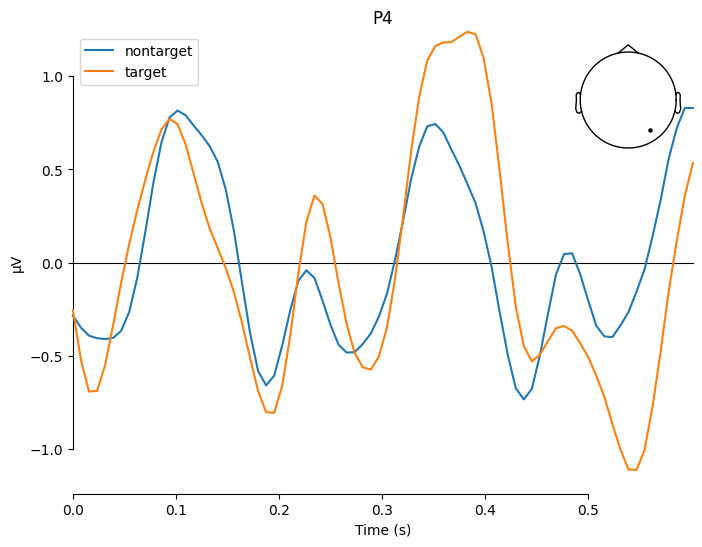

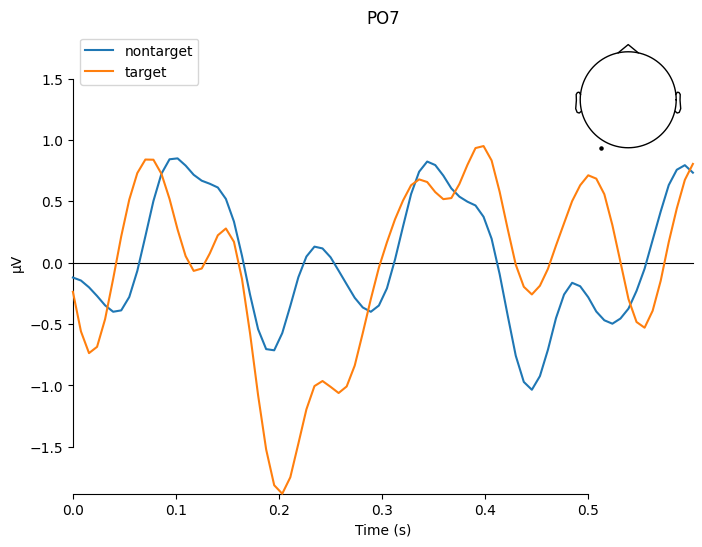

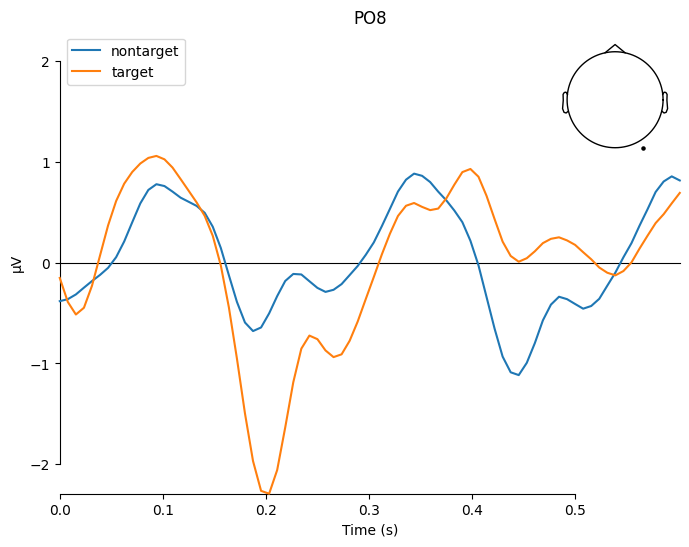

In [9]:
for i in range(8):
    mne.viz.plot_compare_evokeds({'nontarget':nontget,
                                'target':tget},
                                picks = [i])

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier    
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import DistanceMetric
from sklearn.model_selection import LeaveOneOut, cross_val_score, KFold
from sklearn.metrics import f1_score
from sklearn.metrics import explained_variance_score
from mne.decoding import Vectorizer
import joblib
import time
import ray
from ray.util.joblib import register_ray


In [1]:
def get_models():
    models = list()
    models.append(('lda',LinearDiscriminantAnalysis()))
    models.append(('svc',SVC(probability=True)))
    models.append(('knn',KNeighborsClassifier(n_neighbors=3, metric='manhattan')))
    return models

def get_models2():
    models = list()
    models.append(('lr',LogisticRegression()))
    models.append(('lda',LinearDiscriminantAnalysis()))
    models.append(('svc',SVC(kernel = 'linear', probability=True)))
#     models.append(('svc',SVC(probability=True)))
    return models

def get_models3():
    models = list()
    models.append(('lr',LogisticRegression()))
    models.append(('lda',LinearDiscriminantAnalysis()))
    models.append(('svc',LinearSVC()))
    return models


def evaluate_models(models,X_train,X_val,y_train,y_val):
    scores = list()
    register_ray()
#     ray.init()
    for name, model in models:
        with joblib.parallel_backend('ray'):
            start = time.time()
            model.fit(X_train,y_train)
            end = time.time()
        print(f"Time elapsed for {name} is {end-start}")
        yhat = model.predict(X_val)        
        acc = accuracy_score(y_val,yhat)
        scores.append(acc)
        f1 = f1_score(y_val,yhat)
        scores.append(f1)
        var = explained_variance_score(y_val,yhat)  
        scores.append(var)        
    return scores
#leave one out cross validation
def evaluate_loocv(models, X, Y):
    scores = list()
    loocv = LeaveOneOut()
    for name, model in models:
        model_loocv = model
        acc = cross_val_score(model_loocv, X, Y, cv = loocv)
        scores.append(acc)
    return acc

def evaluate_cv(models, X, Y):
    scores = list()    
    cv = KFold(n_splits = 10, random_state = 1, shuffle = True)
    for name, model in models:
        start = time.time()
        model_cv = model
        acc = cross_val_score(model_cv, X, Y, scoring = 'accuracy', cv = cv)
        end = time.time()
        print(f"Time elapsed for {name} is {end-start}")
        scores.append(acc)
    return acc

In [7]:
X,y = [],[]
for i in range(len(data)):
    epoch = data[i].pick_types(eeg=True)        
    d = epoch.get_data()
    X.append(d)    
    l = epoch.events[:, -1]
    y.append(l)

In [9]:
nY = np.reshape(y, (8*4200)) 
nX = np.reshape(X, (8*4200,8*78))

In [11]:
X_train, X_test, y_train, y_test = train_test_split(nX, nY, train_size = 0.8, random_state=42, stratify = nY)

In [12]:
models = get_models()
scores = evaluate_models(models, X_train, X_test, y_train, y_test)


Time elapsed for lda is 2.366941452026367
Time elapsed for svc is 1805.9578063488007
Time elapsed for knn is 0.013188600540161133


In [13]:
print(scores)

[0.8477678571428572, 0.9139251156920488, -0.02125876913265312, 0.841220238095238, 0.9126054549922189, 0.01910730229591795, 0.7956845238095238, 0.883890063424947, -0.4087906568877555]


In [24]:
d = {1: ["LDA", scores[0], scores[1], scores[2]],
2: ["SVC", scores[3], scores[4], scores[5]],
3: ["kNN", scores[6], scores[7], scores[8]],
}
print ("{:<8} {:<8} {:<20} {:<20} {:<20}".format('Pos','Model','Accuracy','F1 Score','Variance'))
for k, v in d.items():
    m, a, f, va = v
    print ("{:<8} {:<8} {:<20} {:<20} {:<20}".format(k, m, a, f, va))

Pos      Model    Accuracy             F1 Score             Variance            
1        LDA      0.8477678571428572   0.9139251156920488   -0.02125876913265312
2        SVC      0.841220238095238    0.9126054549922189   0.01910730229591795 
3        kNN      0.7956845238095238   0.883890063424947    -0.4087906568877555 


In [ ]:
ensemble = VotingClassifier(estimators=models, voting='soft', weights=[scores[0],scores[3],scores[6]])
start = time.time()
ensemble.fit(X_train, y_train)
end = time.time()
yhat = ensemble.predict(X_test)
acc = accuracy_score(y_test, yhat)


In [18]:
f1 = f1_score(y_test,yhat)
var = explained_variance_score(y_test,yhat)  

print(f'Weighted Avg Accuracy: {acc*100}, F1 Score: {f1*100}, Variance Score: {var}')
print(f"Time elapsed is {end-start}")

Weighted Avg Accuracy: 84.77678571428572, F1 Score: 91.52373850360428, Variance Score: 0.02433051658163221
Time elapsed is 1828.5559713840485


In [45]:
#Second set of models
models2 = get_models2()
scores2 = evaluate_models(models2, X_train, X_test, y_train, y_test)

Time elapsed for lr is 2.880462884902954
Time elapsed for lda is 2.7103497982025146
Time elapsed for svc is 630.740761756897


In [46]:
print(scores2)

[0.8333333333333334, 0.9090909090909091, 0.0, 0.8477678571428572, 0.9139251156920488, -0.02125876913265312, 0.8333333333333334, 0.9090909090909091, 0.0]


In [47]:
d = {1: ["Linear Regression", scores2[0], scores2[1], scores2[2]],
2: ["LDA", scores2[3], scores2[4], scores2[5]],
3: ["Linear SVC", scores2[6], scores2[7], scores2[8]],
}
print ("{:<8} {:<20} {:<20} {:<20} {:<20}".format('Pos','Model','Accuracy','F1 Score','Variance'))
for k, v in d.items():
    m, a, f, va = v
    print ("{:<8} {:<20} {:<20} {:<20} {:<20}".format(k, m, a, f, va))

Pos      Model                Accuracy             F1 Score             Variance            
1        Linear Regression    0.8333333333333334   0.9090909090909091   0.0                 
2        LDA                  0.8477678571428572   0.9139251156920488   -0.02125876913265312
3        Linear SVC           0.8333333333333334   0.9090909090909091   0.0                 


In [48]:
#Ensemble with the second model
ensemble2 = VotingClassifier(estimators=models2, voting='soft', weights=[scores2[0],scores2[3],scores2[6]])
start = time.time()
ensemble2.fit(X_train, y_train)
end = time.time()
yhat2 = ensemble2.predict(X_test)
acc2 = accuracy_score(y_test, yhat2)
f1_2 = f1_score(y_test,yhat2)
var2 = explained_variance_score(y_test,yhat2)  



NameError: name 'score' is not defined

In [49]:
print(f'Weighted Avg Accuracy: {acc*100}, F1 Score: {f1_2*100}, Variance Score: {var2}')
print(f"Time elapsed is {end-start}")

Weighted Avg Accuracy: 84.77678571428572, F1 Score: 90.9090909090909, Variance Score: 0.0
Time elapsed is 634.404547214508


In [59]:
#With leave one out cross validation
#It was observed that LinearSVC and SVC with linear kernel reach the same outputs. 
#As loocv requires a lot of time for computation, LinearSVC is used instead. 
models_cv = get_models3()
scores_cv = evaluate_cv(models_cv,nX,nY)
for i in range(len(scores_cv)):
    print(f' Accuracy: {scores_cv[i]*100}')

Time elapsed for lr is 1.8227035999298096
Time elapsed for lda is 27.427282094955444
Time elapsed for svc is 31.456557273864746
 Accuracy: 83.51190476190476
 Accuracy: 83.24404761904762
 Accuracy: 83.21428571428572
 Accuracy: 83.15476190476191
 Accuracy: 82.23214285714285
 Accuracy: 83.63095238095238
 Accuracy: 84.22619047619048
 Accuracy: 83.15476190476191
 Accuracy: 82.76785714285714
 Accuracy: 84.19642857142857


In [ ]:
###In this case loocv was combined with ensemble 
models_ens_loocv = ensemble2
scores_ens_loocv = evaluate_loocv(models_ens_loocv,nX,nY)
print(scores_ens_loocv)

# NUdata

In [61]:
ls

ALSdata.pickle      Filtering.ipynb        Untitled.ipynb
BMI.ipynb           Model.ipynb            first_trial.tar.xz
BNCI2015003.pickle  Spatio-temporal.ipynb  notebooks/
EPFLP300.pickle     TenHealthyData.pickle  trial_23_08_2022_12_48_41/


In [62]:
def loaddata(fname):
    with open(fname,'rb') as handle:
        data = pickle.load(handle)
    return data
fname = 'TenHealthyData.pickle'
data = loaddata(fname)

In [63]:
X,y = [],[]
for i in range(len(data)):
    epoch = data[i].pick_types(eeg=True)        
    d = epoch.get_data()
    X.append(d)    
    l = epoch.events[:, -1]
    y.append(l)

In [68]:
X = np.asarray(X)
y = np.asarray(y)
print(X.shape)
print(y.shape)

(10, 1728, 16, 78)
(10, 1728)


In [69]:
nY = np.reshape(y, (10*1728)) 
nX = np.reshape(X, (10*1728,16*78))

In [70]:
X_train, X_test, y_train, y_test = train_test_split(nX, nY, train_size = 0.8, random_state=42, stratify = nY)

In [71]:
models = get_models()
scores = evaluate_models(models, X_train, X_test, y_train, y_test)

Time elapsed for lda is 3.063108444213867
Time elapsed for svc is 400.97955536842346
Time elapsed for knn is 0.012437105178833008


In [72]:
d = {1: ["LDA", scores[0], scores[1], scores[2]],
2: ["SVC", scores[3], scores[4], scores[5]],
3: ["kNN", scores[6], scores[7], scores[8]],
}
print ("{:<8} {:<8} {:<20} {:<20} {:<20}".format('Pos','Model','Accuracy','F1 Score','Variance'))
for k, v in d.items():
    m, a, f, va = v
    print ("{:<8} {:<8} {:<20} {:<20} {:<20}".format(k, m, a, f, va))

Pos      Model    Accuracy             F1 Score             Variance            
1        LDA      0.8903356481481481   0.9354673931551167   0.21811402874228403 
2        SVC      0.8804976851851852   0.9321058688147296   0.20247456114969142 
3        kNN      0.8318865740740741   0.9043621399176955   -0.15060221354166625


In [73]:
ensemble = VotingClassifier(estimators=models, voting='soft', weights=[scores[0],scores[3],scores[6]])
start = time.time()
ensemble.fit(X_train, y_train)
end = time.time()
yhat = ensemble.predict(X_test)
acc = accuracy_score(y_test, yhat)

In [74]:
print(f'Weighted Avg Accuracy: {acc*100}, F1 Score: {f1_2*100}, Variance Score: {var2}')
print(f"Time elapsed is {end-start}")

Weighted Avg Accuracy: 88.91782407407408, F1 Score: 90.9090909090909, Variance Score: 0.0
Time elapsed is 425.46618008613586


In [75]:
#Second set of models
models2 = get_models2()
scores2 = evaluate_models(models2, X_train, X_test, y_train, y_test)

Time elapsed for lr is 3.026914119720459
Time elapsed for lda is 3.2291183471679688
Time elapsed for svc is 303.44713854789734


In [76]:
d = {1: ["Linear Regression", scores2[0], scores2[1], scores2[2]],
2: ["LDA", scores2[3], scores2[4], scores2[5]],
3: ["Linear SVC", scores2[6], scores2[7], scores2[8]],
}
print ("{:<8} {:<20} {:<20} {:<20} {:<20}".format('Pos','Model','Accuracy','F1 Score','Variance'))
for k, v in d.items():
    m, a, f, va = v
    print ("{:<8} {:<20} {:<20} {:<20} {:<20}".format(k, m, a, f, va))

Pos      Model                Accuracy             F1 Score             Variance            
1        Linear Regression    0.8333333333333334   0.9090909090909091   0.0                 
2        LDA                  0.8903356481481481   0.9354673931551167   0.21811402874228403 
3        Linear SVC           0.8333333333333334   0.9090909090909091   0.0                 


In [77]:
#Ensemble with the second model
ensemble2 = VotingClassifier(estimators=models2, voting='soft', weights=[scores2[0],scores2[3],scores2[6]])
start = time.time()
ensemble2.fit(X_train, y_train)
end = time.time()
yhat2 = ensemble2.predict(X_test)
acc2 = accuracy_score(y_test, yhat2)
f1_2 = f1_score(y_test,yhat2)
var2 = explained_variance_score(y_test,yhat2)  

In [78]:
print(f'Weighted Avg Accuracy: {acc*100}, F1 Score: {f1_2*100}, Variance Score: {var2}')
print(f"Time elapsed is {end-start}")

Weighted Avg Accuracy: 88.91782407407408, F1 Score: 92.13987808790503, Variance Score: 0.11460503472222217
Time elapsed is 305.5297751426697


# BNCI Data

In [79]:
def loaddata(fname):
    with open(fname,'rb') as handle:
        data = pickle.load(handle)
    return data
fname = 'BNCI2015003.pickle'
data = loaddata(fname)

In [82]:
X,y = [],[]
for i in range(len(data)):
    epoch = data[i].pick_types(eeg=True)
    d = epoch.get_data()
    # print(d)
    X.append(d)    
    l = epoch.events[:, -1]
    y.append(l)

In [83]:
nX = np.concatenate(X)
nX.shape
nX = np.reshape(nX,[25200,8*128])

In [84]:
nY = np.empty(shape = y[0].shape)
for i in range(len(y)):
    nY = np.concatenate([nY,y[i]])
nY = np.concatenate(y)
nY.shape

(25200,)

In [85]:
X_train, X_test, y_train, y_test = train_test_split(nX, nY, train_size = 0.8, random_state=42, stratify = nY)

In [86]:
models = get_models()
scores = evaluate_models(models, X_train, X_test, y_train, y_test)

Time elapsed for lda is 3.3263192176818848
Time elapsed for svc is 523.6805527210236
Time elapsed for knn is 0.015560150146484375


In [87]:
d = {1: ["LDA", scores[0], scores[1], scores[2]],
2: ["SVC", scores[3], scores[4], scores[5]],
3: ["kNN", scores[6], scores[7], scores[8]],
}
print ("{:<8} {:<8} {:<20} {:<20} {:<20}".format('Pos','Model','Accuracy','F1 Score','Variance'))
for k, v in d.items():
    m, a, f, va = v
    print ("{:<8} {:<8} {:<20} {:<20} {:<20}".format(k, m, a, f, va))

Pos      Model    Accuracy             F1 Score             Variance            
1        LDA      0.8831349206349206   0.9375596310823703   -0.14447366255143979
2        SVC      0.8928571428571429   0.9433962264150945   0.0                 
3        kNN      0.8367063492063492   0.9100644738279969   -0.6975798353909459 


In [88]:
ensemble = VotingClassifier(estimators=models, voting='soft', weights=[scores[0],scores[3],scores[6]])
start = time.time()
ensemble.fit(X_train, y_train)
end = time.time()
yhat = ensemble.predict(X_test)
acc = accuracy_score(y_test, yhat)

In [89]:
print(f'Weighted Avg Accuracy: {acc*100}, F1 Score: {f1_2*100}, Variance Score: {var2}')
print(f"Time elapsed is {end-start}")

Weighted Avg Accuracy: 89.24603174603175, F1 Score: 92.13987808790503, Variance Score: 0.11460503472222217
Time elapsed is 549.054366350174


In [90]:
#Second set of models
models2 = get_models2()
scores2 = evaluate_models(models2, X_train, X_test, y_train, y_test)

Time elapsed for lr is 4.660918951034546
Time elapsed for lda is 3.6467854976654053
Time elapsed for svc is 535.5189933776855


In [91]:
d = {1: ["Linear Regression", scores2[0], scores2[1], scores2[2]],
2: ["LDA", scores2[3], scores2[4], scores2[5]],
3: ["Linear SVC", scores2[6], scores2[7], scores2[8]],
}
print ("{:<8} {:<20} {:<20} {:<20} {:<20}".format('Pos','Model','Accuracy','F1 Score','Variance'))
for k, v in d.items():
    m, a, f, va = v
    print ("{:<8} {:<20} {:<20} {:<20} {:<20}".format(k, m, a, f, va))

Pos      Model                Accuracy             F1 Score             Variance            
1        Linear Regression    0.8932539682539683   0.943558539655896    0.0006189300411522103
2        LDA                  0.8831349206349206   0.9375596310823703   -0.14447366255143979
3        Linear SVC           0.8928571428571429   0.9433962264150945   0.0                 


In [93]:
#Ensemble with the second model
ensemble2 = VotingClassifier(estimators=models2, voting='soft', weights=[scores2[0],scores2[3],scores2[6]])
start = time.time()
ensemble2.fit(X_train, y_train)
end = time.time()
yhat2 = ensemble2.predict(X_test)
acc2 = accuracy_score(y_test, yhat2)
f1_2 = f1_score(y_test,yhat2)
var2 = explained_variance_score(y_test,yhat2)  

In [94]:
print(f'Weighted Avg Accuracy: {acc*100}, F1 Score: {f1_2*100}, Variance Score: {var2}')
print(f"Time elapsed is {end-start}")

Weighted Avg Accuracy: 89.24603174603175, F1 Score: 94.31424067262218, Variance Score: -0.012927983539094523
Time elapsed is 538.2960698604584


# EPFLP300

In [4]:
def loaddata(fname):
    with open(fname,'rb') as handle:
        data = pickle.load(handle)
    return data
fname = 'EPFLP300.pickle'
data = loaddata(fname)

In [5]:
X,y = [],[]
for i in range(len(data)):
    epoch = data[i].pick_types(eeg=True)
    d = epoch.get_data()
    # print(d)
    X.append(d)    
    l = epoch.events[:, -1]
    y.append(l)

In [6]:
nX = np.concatenate(X)
nX.shape
nX = np.reshape(nX,[26640,32*77])

In [7]:
nY = np.empty(shape = y[0].shape)
for i in range(len(y)):
    nY = np.concatenate([nY,y[i]])
nY = np.concatenate(y)
nY.shape

(26640,)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(nX, nY, train_size = 0.8, random_state=42, stratify = nY)

In [102]:
models = get_models()
scores = evaluate_models(models, X_train, X_test, y_train, y_test)

Time elapsed for lda is 10.559244632720947
Time elapsed for svc is 2117.058471441269
Time elapsed for knn is 0.03615713119506836


In [103]:
d = {1: ["LDA", scores[0], scores[1], scores[2]],
2: ["SVC", scores[3], scores[4], scores[5]],
3: ["kNN", scores[6], scores[7], scores[8]],
}
print ("{:<8} {:<8} {:<20} {:<20} {:<20}".format('Pos','Model','Accuracy','F1 Score','Variance'))
for k, v in d.items():
    m, a, f, va = v
    print ("{:<8} {:<8} {:<20} {:<20} {:<20}".format(k, m, a, f, va))

Pos      Model    Accuracy             F1 Score             Variance            
1        LDA      0.8348348348348348   0.9075241698192518   -0.08659605551497429
2        SVC      0.8333333333333334   0.9090909090909091   0.0                 
3        kNN      0.81006006006006     0.8927966101694915   -0.28802856910965   


In [104]:
ensemble = VotingClassifier(estimators=models, voting='soft', weights=[scores[0],scores[3],scores[6]])
start = time.time()
ensemble.fit(X_train, y_train)
end = time.time()
yhat = ensemble.predict(X_test)
acc = accuracy_score(y_test, yhat)

In [105]:
print(f'Weighted Avg Accuracy: {acc*100}, F1 Score: {f1_2*100}, Variance Score: {var2}')
print(f"Time elapsed is {end-start}")

Weighted Avg Accuracy: 83.42717717717719, F1 Score: 94.31424067262218, Variance Score: -0.012927983539094523
Time elapsed is 2186.670909166336


In [9]:
#Second set of models
#SVC instead of SVC linear was used
ray.init()
models2 = get_models2()
scores2 = evaluate_models(models2, X_train, X_test, y_train, y_test)

2022-10-26 05:15:45,368	WARNING services.py:1884 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 1073741824 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=10.24gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2022-10-26 05:15:46,520	INFO worker.py:1518 -- Started a local Ray instance.
2022-10-26 05:15:48,395	WARNING pool.py:591 -- The 'context' argument is not supported using ray. Please refer to the documentation for how to control ray initialization.
(PoolActor pid=85810) /.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
(PoolActor pid=85810) STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.
(PoolActor pid=85810) 
(PoolActor pid=

Time elapsed for lr is 13.319475889205933
Time elapsed for lda is 10.86408257484436
Time elapsed for svc is 2151.8000571727753


In [10]:
d = {1: ["Linear Regression", scores2[0], scores2[1], scores2[2]],
2: ["LDA", scores2[3], scores2[4], scores2[5]],
3: ["Linear SVC", scores2[6], scores2[7], scores2[8]],
}
print ("{:<8} {:<20} {:<20} {:<20} {:<20}".format('Pos','Model','Accuracy','F1 Score','Variance'))
for k, v in d.items():
    m, a, f, va = v
    print ("{:<8} {:<20} {:<20} {:<20} {:<20}".format(k, m, a, f, va))

Pos      Model                Accuracy             F1 Score             Variance            
1        Linear Regression    0.581081081081081    0.7108808290155441   -1.6749289830370908 
2        LDA                  0.8348348348348348   0.9075241698192518   -0.08659605551497429
3        Linear SVC           0.8333333333333334   0.9090909090909091   0.0                 


In [11]:
#Ensemble with the second model
ensemble2 = VotingClassifier(estimators=models2, voting='soft', weights=[scores2[0],scores2[3],scores2[6]])
start = time.time()
ensemble2.fit(X_train, y_train)
end = time.time()
yhat2 = ensemble2.predict(X_test)
acc2 = accuracy_score(y_test, yhat2)
f1_2 = f1_score(y_test,yhat2)
var2 = explained_variance_score(y_test,yhat2)  

/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [13]:
print(f'Weighted Avg Accuracy: {acc2*100}, F1 Score: {f1_2*100}, Variance Score: {var2}')
print(f"Time elapsed is {end-start}")

Weighted Avg Accuracy: 83.25825825825825, F1 Score: 90.83812654067378, Variance Score: -0.019560100641181855
Time elapsed is 2202.3035893440247
